In [1]:
import numpy as np

#===============================================================================

def S0(x):
    return 1.0

def S(x):
    return 1.0 / (1.0 + np.exp(-x))

def dS_dOut(out):
    return out * (1 - out)

#===============================================================================

class ForwardResult:
    pass

#===============================================================================

def forwardEvalute(x_with_intercept, a, b, cfg = None):
    z = np.dot(a.T, x_with_intercept)
    o = np.zeros(shape=z.shape)
    for i in range(len(z)):
        if i == 0:
            o[i] = S0(z[i])
        else:
            o[i] = S(z[i])
    Fhat = np.dot(o.T, b)

    res = ForwardResult()
    res.x_with_intercept = x_with_intercept
    res.a = a
    res.b = b
    res.z = z
    res.o = o
    res.Fhat = Fhat

    return res

def partial_DL_db(fwd, y, cfg = None):
    dL_db = (fwd.Fhat - y[0]) * fwd.o
    return dL_db

def partial_DL_da(fwd, y, cfg = None):
    (N, M) = fwd.a.shape
    dL_da = np.zeros((N, M))
    for j in range(N):
        for m in range(M):
            dL_da[j, m] = (fwd.Fhat - y[0]) * fwd.b[m] * (dS_dOut(fwd.o[m])) * fwd.x_with_intercept[j]
    return dL_da

def partial_DL_db_compute(fwd, y, cfg):
    x_with_intercept = fwd.x_with_intercept
    a = fwd.a
    b = fwd.b
    (n, m) = a.shape
    eps = 0.0001

    dL_db = np.zeros(m)
    for i in range(m):
        db = np.zeros(m)
        db[i] = eps
        f_db_plus = forwardEvalute(x_with_intercept, a, b + db, cfg)
        f_db_plus_eval = np.square(f_db_plus.Fhat - y[0]) / 2.0

        f_db_minus = forwardEvalute(x_with_intercept, a, b - db, cfg)
        f_db_minus_eval = np.square(f_db_minus.Fhat - y[0]) / 2.0

        dL_db[i] = (f_db_plus_eval - f_db_minus_eval) / (2 * eps);
    return dL_db

def partial_DL_da_compute(fwd, y, cfg = None):
    x_with_intercept = fwd.x_with_intercept
    a = fwd.a
    b = fwd.b
    (N, M) = a.shape
    eps = 0.0001

    dL_da = np.zeros(a.shape)
    for j in range(N):
        for m in range(M):
            da = np.zeros((N, M))
            da[j, m] = eps
            f_da_plus = forwardEvalute(x_with_intercept, a + da, b, cfg)
            f_da_plus_eval = np.square(f_da_plus.Fhat - y[0]) / 2.0

            f_da_minus = forwardEvalute(x_with_intercept, a - da, b, cfg)
            f_da_minus_eval = np.square(f_da_minus.Fhat - y[0]) / 2.0

            dL_da[j, m] = (f_da_plus_eval - f_da_minus_eval) / (2 * eps);
    return dL_da

>> Current emppirical risk: [[3.625]]
>> Empirical risk gradient l2 norm:  14.427485704376906


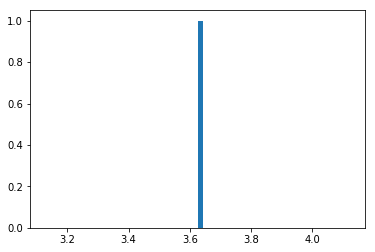

In [11]:
import os, sys
import matplotlib.pyplot as plt

dirScript = os.path.dirname(os.path.abspath(sys.argv[0]))
sys.path.append(dirScript)


X = None              # Data Matrix, which stores examples by rows
Y = None              # Label Vector, which stores examples by items
Indicies = None       # Indicies of examples used for empiricalRisk() and 

class Configuration:
   pass

cfg = Configuration() # Configuration of Neural NEt

def makeRandom(x):
    return np.random.random(x.shape)

def packParameterToVector(a, b):
    '''
    a - is a matrix with coefficients for neural net
    b - another coefficients
    '''
    aAsVector = a.reshape((a.size, 1))
    bAsVector = b.reshape((b.size, 1))

    allParameters = np.concatenate( (aAsVector, bAsVector) )
    return allParameters

def unpackParameterFromVector(allParams, cfg):
    '''
    a - is a matrix with coefficients for neural net
    b - another coefficients
    '''
    a = allParams[0:cfg.n * cfg.m, 0]
    b = allParams[cfg.n * cfg.m:, 0]

    a = a.reshape( (cfg.n, cfg.m) )
    b = b.reshape( (cfg.m, 1) )

    return a,b

def empiricalRisk(x):
    '''
    x is a parameters of neural net which consist of [a, b]
    step1 - from x extract [a, b]
    step2 - which examples we should take
    step3 - substitute into forwardEvalute(...)
    '''

    a, b = unpackParameterFromVector(x, cfg)
    results = 0.0
    
    for i in range(Indicies.size):
        xi = X[i, :]
        xi = xi.reshape( (xi.size, 1) )
        yi = Y[i]   

        fwd = forwardEvalute(xi, a, b, cfg)
        results += ((fwd.Fhat - yi) ** 2) / 2.0

    return results / Indicies.size

def empiricalRiskGradient(x):
    '''
    Iterate through all indicies Indicies and take x[i] y[i]
    step1 - forwardEvalute
    step2 - np.asarray([partial_DL_da(fwd, y), partial_DL_db(fwd, y)])
    step3 - accumulate final gradient
    '''
    
    a, b = unpackParameterFromVector(x, cfg)
    gradient = None
    
    for i in range(Indicies.size):
        xi = X[i, :]
        xi = xi.reshape( (xi.size, 1) )
        yi = Y[i]   

        fwd = forwardEvalute(xi, a, b, cfg)
        grad_a = partial_DL_da(fwd, yi)
        grad_b = partial_DL_db(fwd, yi)

        grad_to_all_params = packParameterToVector(grad_a, grad_b)

        if gradient is None:
            gradient = grad_to_all_params
        else:
            gradient += grad_to_all_params
 
    return gradient / Indicies.size
 
if __name__ == "__main__":
    #global X, Y

    # X global variable, matrix, store all examples by ROWS
    X = np.array([[1, 2, 3, 1.0],
                  [4, 5, 6, 1.0]
                 ]
                 )

    # Y global variable, column, store all correct values
    Y = np.array([[7],
                  [9]
                 ])

    # Indicies by which pull examples
    Indicies = np.asarray(np.array([[1, 0]]))

    cfg.m = 10                    # number of activation functions
    cfg.n = X.shape[1]            # number of input attributes
    cfg.totalSamples = X.shape[0] # total number of examples

    a = np.zeros((cfg.n, cfg.m))
    b = np.ones((cfg.m, 1))

    allParams = packParameterToVector(a, b)
    score = empiricalRisk(allParams)
    print(">> Current emppirical risk:", score)

    
    
    grad = empiricalRiskGradient(allParams)
    print(">> Empirical risk gradient l2 norm: ", np.linalg.norm(grad))
    
score, bins = np.histogram(score, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, score, align='center', width=width)
plt.show()

[0, 1, 2, 3]


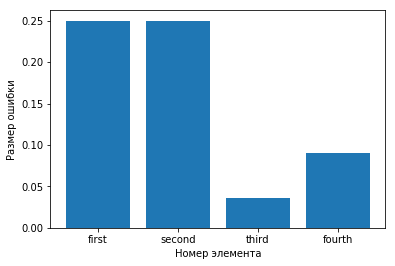

[0, 1, 2, 3]


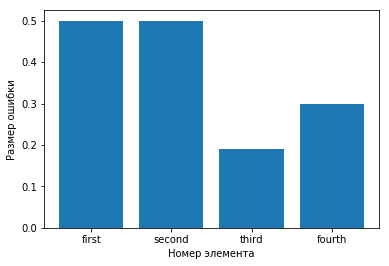

In [36]:
yReal = np.array([1,2,3,5])       # Ground thruth
yHat = np.array([1.5, 2.5, 3.19, 4.7]) # Predictions from our predictor

error = np.abs(yReal - yHat)
errorSqr = error * error

x = range(len(errorSqr))
print (list(x))
ax = plt.gca()
ax.bar(x, errorSqr, align='center') 
ax.set_xticks(x)
ax.set_xticklabels(('first', 'second', 'third', 'fourth'))
plt.xlabel('Номер элемента')
plt.ylabel('Размер ошибки');
plt.show()

x = range(len(error))
print (list(x))
ax = plt.gca()
ax.bar(x, error, align='center') 
ax.set_xticks(x)
ax.set_xticklabels(('first', 'second', 'third', 'fourth'))
plt.xlabel('Номер элемента')
plt.ylabel('Размер ошибки');
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


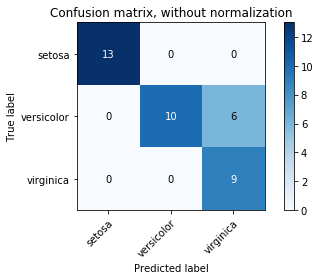

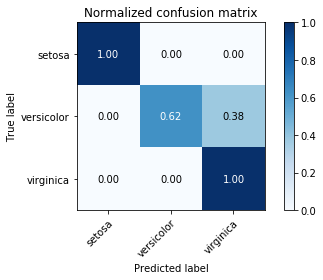

In [41]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()